# **Sentiment Analysis of Amazon Reviews**

**Group 23:**
Shashwat Kumar(sk5520), Saatvik Saradhi Inampudi(si2464), Tanner Hillison(tkh2119), Mengxi Liu(mi5189), Gaifan Zhang(gz2360)

## **Problem Statement**
The aim of this project is to analyze customer reviews from Amazon’s Fine Food category and predict the sentiment of a given review (Negative/Neutral/Positive) using various machine learning (ML) techniques. Sentiment analysis on such large-scale data can help businesses better understand customer preferences, improve product recommendations, and adjust marketing strategies. This problem falls under supervised learning with multi-class text classification as the core task where we determine the performance of our model by analyzing the accuracy as well as the confusion matrix.

## **Dataset**
**Dataset link**: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

The dataset consists of 568,454 reviews from Amazon’s Fine Food category, collected over a period of 10 years. It contains detailed review information, including product and user metadata, which provides a rich context for sentiment analysis. Each review includes the following fields:

**• Id:** Row identifier for each review entry.

**• ProductId:** Unique identifier for the product being reviewed.

**• UserId:** Unique identifier for the user who submitted the review.

**• ProfileName:** Profile name of the user submitting the review.

**• HelpfulnessNumerator:** Number of users who found the review helpful.

**• HelpfulnessDenominator:** Total number of users who found the review helpful or not.

**• Score:** Rating assigned to the product (an integer between 1 and 5).

**• Time:** Unix timestamp representing when the review was submitted.

**• Summary:** Summary provided by the reviewer.

**• Text:** The main content of the review describing what the customer felt about the product.



In [1]:
!pip install portalocker
!pip install torchmetrics
!pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 torchtext==0.17.0 --index-url https://download.pytorch.org/whl/cu121
!pip install torchdata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 48.9 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.3/757.3 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 104.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 109.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import ast
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from wordcloud import WordCloud
#from torchtext.vocab import build_vocab_from_iterator
from gensim.models import Word2Vec
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load the data
df = pd.read_csv("/content/drive/MyDrive/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## **1. Initial data exploration**

###Distribution of Ratings

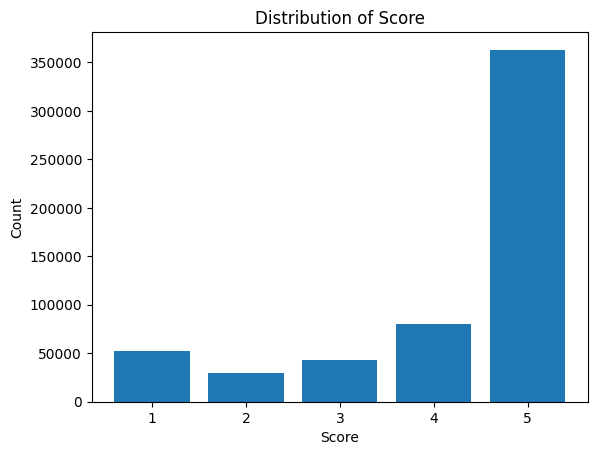

In [4]:
score_counts = df['Score'].value_counts().sort_index()
plt.bar(score_counts.index, score_counts.values)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Score')
plt.show()

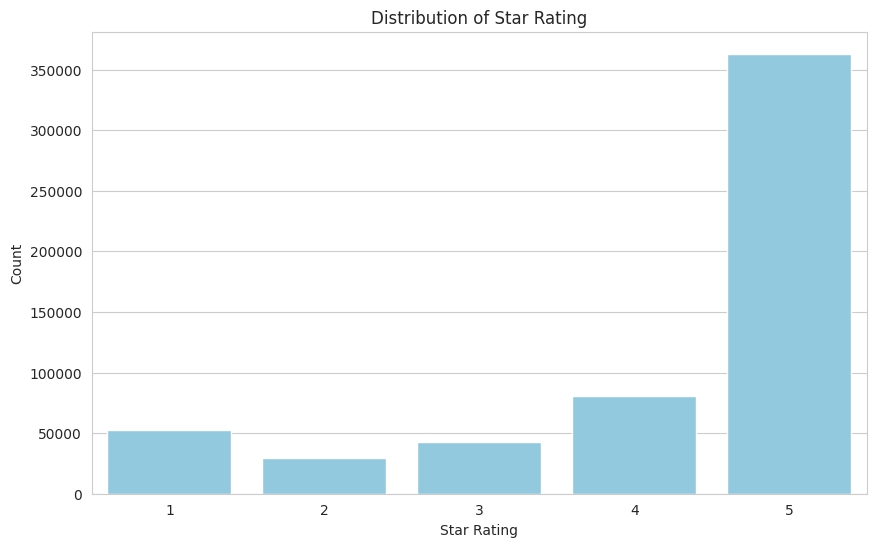

In [5]:
df.columns.values.tolist()

score_counts = df['Score'].value_counts().sort_index()
sns.set_style("whitegrid")

plt.figure(figsize = (10,6))
sns.barplot(x=score_counts.index, y=score_counts.values, color = 'skyblue')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Distribution of Star Rating')
plt.show()

###Distribution of Sentiment (the target)

In [6]:
def classify_sentiment(score):
    if score >= 4:
        return 'good'
    if score == 3:
        return 'neutral'
    if score <= 2:
        return 'bad'

df['Sentiment'] = df['Score'].apply(classify_sentiment)

In [7]:
print('Distribution of Sentiment Values:')
print(df['Sentiment'].value_counts())
print()
print('Percentage Distribution of Sentiment Values:')
print(df['Sentiment'].value_counts(normalize=True) * 100)

Distribution of Sentiment Values:
Sentiment
good       443777
bad         82037
neutral     42640
Name: count, dtype: int64

Percentage Distribution of Sentiment Values:
Sentiment
good       78.067355
bad        14.431599
neutral     7.501047
Name: proportion, dtype: float64


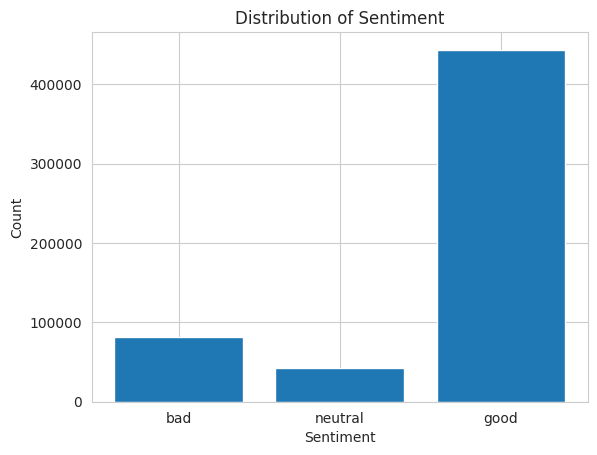

In [8]:
senti_counts = df['Sentiment'].value_counts()
order = ['bad', 'neutral', 'good']
senti_counts = senti_counts.reindex(order)

plt.bar(senti_counts.index, senti_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiment')
plt.show()

## **2. Data Preprocessing**

###Text Cleaning

In [9]:
# define URL pattern
URL = r'http[s]?://\S+|www\.\S+'
# define HTML tag pattern
HTML_TAGS = r'<.*?>'
# define whitespace
WHITESPACE = r'\s+'

In [10]:
def cleaner(review):
  # remove punctuation
  review = review.translate(str.maketrans('', '', string.punctuation))

  # remove numbers
  review = review.translate(str.maketrans('', '', string.digits))

  # remove URLs
  review = re.sub(URL, '', review)

  # remove HTML tags
  review = re.sub(HTML_TAGS, '', review)

  # lowercase all words
  review = review.lower()

  # replace multiple whitespaces with one whitespace
  review = re.sub(WHITESPACE, ' ', review)

  return review

In [11]:
# apply the text cleaner
df['Text'] = df['Text'].apply(cleaner)
df['Text'][:5]

,Text
0,i have bought several of the vitality canned d...
1,product arrived labeled as jumbo salted peanut...
2,this is a confection that has been around a fe...
3,if you are looking for the secret ingredient i...
4,great taffy at a great price there was a wide ...


###Tokenization

In [12]:
df['Text'] = df['Text'].str.split()
df['Text'][:5]

,Text
0,"[i, have, bought, several, of, the, vitality, ..."
1,"[product, arrived, labeled, as, jumbo, salted,..."
2,"[this, is, a, confection, that, has, been, aro..."
3,"[if, you, are, looking, for, the, secret, ingr..."
4,"[great, taffy, at, a, great, price, there, was..."


###Stopword Removal

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
# define stopwords
stop_words = set(stopwords.words('english'))

# subtract negative stop words like no, not, don't etc.. from total_stopwords
negative_stop_words = set(word for word in stop_words
                          if "n't" in word or 'no' in word)

stop_words = stop_words - negative_stop_words
stop_words.add("one")

print(stop_words)

{'about', 'other', 'me', 's', 'hers', 'these', 'were', 'i', 'them', 'has', 'just', 'their', 'here', 'he', 'through', 'him', 'most', 'itself', 'there', 'from', 'who', 'our', 'over', 'how', "you're", 'and', 'ourselves', 'they', 'because', 'are', 'be', 'couldn', 'than', 'above', 'mightn', 'aren', 'will', 'until', 'we', 'll', 'your', 'been', 'won', 'her', 'further', 'yourselves', 'y', 'this', 'did', 'such', 'his', 'on', 'again', 'same', 'those', 'does', 'had', 'doing', 'when', 'some', 'doesn', "you'll", 'with', 't', 'what', 'then', 'for', "it's", 'very', 'whom', 'didn', 'off', 'd', 'yours', 'each', 'haven', 'shan', 'shouldn', 'it', 'hasn', 'ain', 'by', 'which', 'mustn', 'o', 'its', 'don', 'to', 'she', 'a', 'in', 'below', 'wouldn', 'before', 'once', 'out', 'both', 'being', 'having', 'any', 'more', 'can', 'down', 'you', 'so', 'theirs', 'at', 'ours', 'the', 'm', 'or', 'is', 'where', 'himself', 'was', 'why', 'one', 'if', 'while', "you've", 'between', 'too', 'few', 'do', 'as', 'am', 'my', 'were

In [15]:
# remove stopwords
df['Text'] = df['Text'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
df['Text'][:5]

,Text
0,"[bought, several, vitality, canned, dog, food,..."
1,"[product, arrived, labeled, jumbo, salted, pea..."
2,"[confection, around, centuries, light, pillowy..."
3,"[looking, secret, ingredient, robitussin, beli..."
4,"[great, taffy, great, price, wide, assortment,..."


###Lemmatization

In [16]:
def get_wordnet_pos(tag):
  if tag.startswith('J'):
      return wordnet.ADJ
  elif tag.startswith('V'):
      return wordnet.VERB
  elif tag.startswith('N'):
      return wordnet.NOUN
  elif tag.startswith('R'):
      return wordnet.ADV
  else:
      return wordnet.NOUN

def lemmatize_list(text):
  pos_tags = pos_tag(text)
  lemmatizer = WordNetLemmatizer()
  lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
  return lemmatized_words

In [17]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [18]:
df['Text'] = df['Text'].apply(lemmatize_list)
df['Text'][:5]

,Text
0,"[buy, several, vitality, can, dog, food, produ..."
1,"[product, arrive, labeled, jumbo, salt, peanut..."
2,"[confection, around, century, light, pillowy, ..."
3,"[look, secret, ingredient, robitussin, believe..."
4,"[great, taffy, great, price, wide, assortment,..."


In [23]:
# write dataframe to a csv file
df.to_csv('preprocessed_reviews.csv', index=False)

###Word Cloud

In [19]:
def generate_wcloud(text):
  wordcloud = WordCloud(background_color='white')
  wordcloud.generate(text)

  plt.figure(figsize=(15,7))
  plt.axis('off')
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.show()

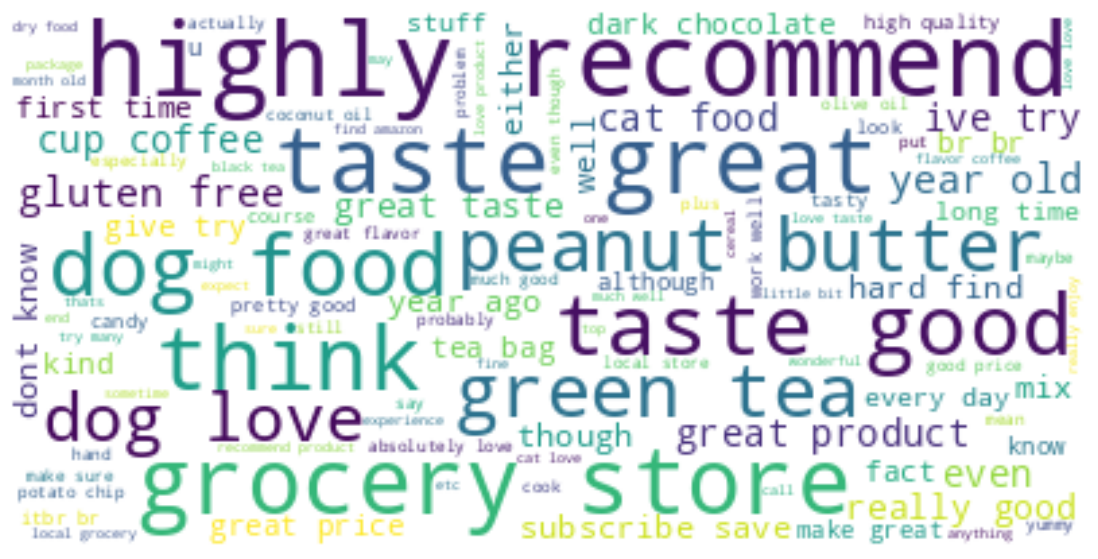

In [20]:
# word cloud for positive reviews
word_lists = df.loc[df['Sentiment']=="good"]['Text']
text = " ".join(word for word_list in word_lists for word in word_list)
generate_wcloud(text)

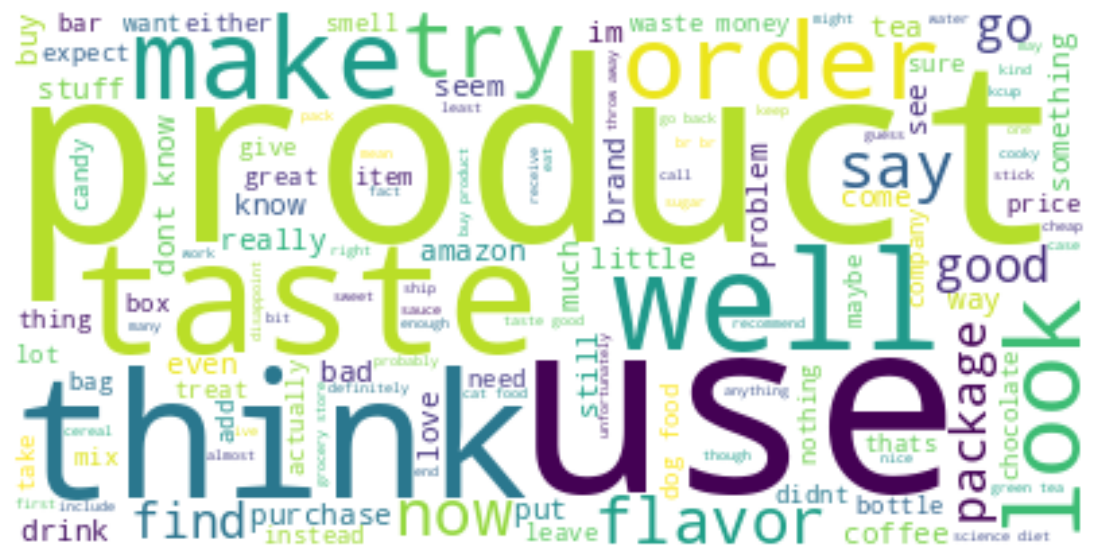

In [21]:
# word cloud for negative reviews
word_lists = df.loc[df['Sentiment']=="bad"]['Text']
text = " ".join(word for word_list in word_lists for word in word_list)
generate_wcloud(text)

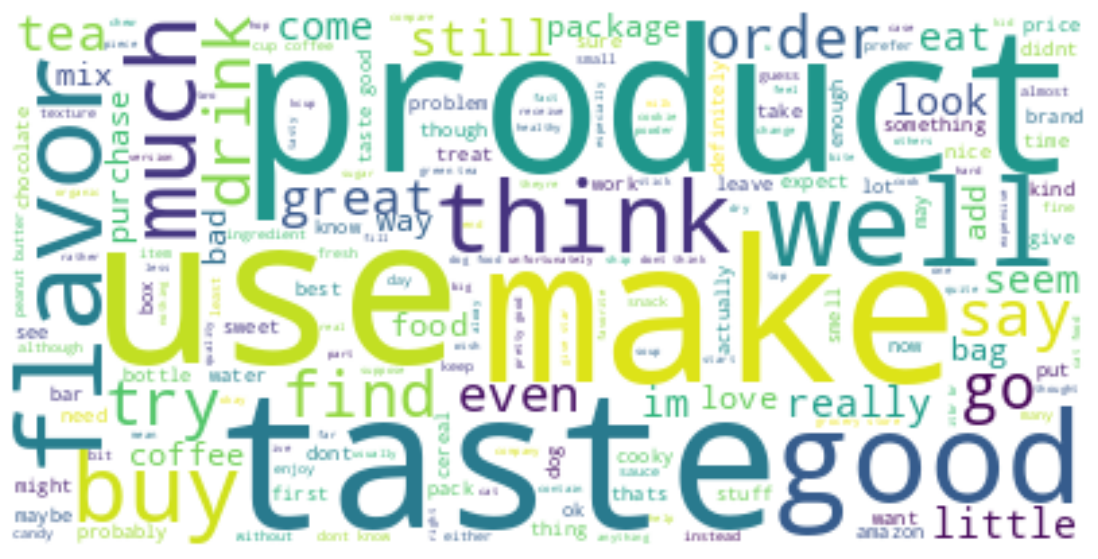

In [22]:
# word cloud for neutral reviews
word_lists = df.loc[df['Sentiment']=="neutral"]['Text']
text = " ".join(word for word_list in word_lists for word in word_list)
generate_wcloud(text)

## **3. Vectorization**

In [3]:
df = pd.read_csv("/content/drive/MyDrive/preprocessed_reviews.csv")

###Train Test Split

In [4]:
df['Text'] = df['Text'].apply(ast.literal_eval)
df = df[df['Text'].apply(lambda x: x != [])]

In [5]:
X = df['Text']
y = df['Sentiment']

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, stratify=df.Sentiment, random_state=42)

In [6]:
X_dev.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_dev.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [7]:
X_dev.shape, X_test.shape

((454762,), (113691,))

###Build Vocabulary

In [8]:
MIN_FREQUENCY = 10

In [8]:
VOCAB = build_vocab_from_iterator(
    X_dev,
    min_freq = MIN_FREQUENCY,
    specials=('<pad>', '<unk>')
)

VOCAB.set_default_index(VOCAB['<unk>'])

In [9]:
len(VOCAB)

28471

###Bag of Words (BoW)

In [59]:
bow_vectorizer = CountVectorizer(vocabulary=VOCAB.get_itos())

bow_X_dev = bow_vectorizer.fit_transform(X_dev.apply(lambda words: ' '.join(words)))
bow_X_test = bow_vectorizer.transform(X_test.apply(lambda words: ' '.join(words)))

###TF-IDF (Term Frequency-Inverse Document Frequency)

In [60]:
tfidf_vectorizer = TfidfVectorizer(vocabulary=VOCAB.get_itos())

tfidf_X_dev = tfidf_vectorizer.fit_transform(X_dev.apply(lambda words: ' '.join(words)))
tfidf_X_test = tfidf_vectorizer.transform(X_test.apply(lambda words: ' '.join(words)))

###Word2Vec

In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [9]:
word2vec = Word2Vec(sentences=X, vector_size=100, window=5, min_count=10, sg=1)

In [10]:
embedding_dim = word2vec.vector_size

In [11]:
#def transform_to_vectors(word_list, model):
    #return [model.wv[word] if word in model.wv else np.zeros(model.vector_size) for word in word_list]

#w2v_X_dev = [transform_to_vectors(words, word2vec) for words in X_dev]
#w2v_X_test = [transform_to_vectors(words, word2vec) for words in X_test]

In [12]:
# convert the labels to numbers
encoder = OrdinalEncoder(categories=[["bad", "neutral", "good"]])
y_dev_ordered = encoder.fit_transform(y_dev.to_numpy().reshape(-1,1)).ravel()
y_test_ordered = encoder.transform(y_test.to_numpy().reshape(-1,1)).ravel()

In [13]:
class Word2VecDataset(Dataset):
    def __init__(self, data, labels, word2vec_model, embedding_dim):
        self.data = data
        self.labels = labels
        self.word2vec = word2vec_model
        self.embedding_dim = embedding_dim

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert words to vectors
        vectors = [torch.tensor(self.word2vec.wv[word]) if word in self.word2vec.wv else torch.zeros(self.embedding_dim) for word in self.data[idx]]
        label = self.labels[idx]
        return torch.stack(vectors), torch.tensor(label)

In [14]:
# Create Dataset instances
train_dataset = Word2VecDataset(X_dev, y_dev_ordered, word2vec, embedding_dim)
test_dataset = Word2VecDataset(X_test, y_test_ordered, word2vec, embedding_dim)

In [15]:
def collate_batch(batch):
  sequences, labels = zip(*batch)
  padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
  labels = torch.tensor(labels)
  return padded_sequences.to(DEVICE), labels.to(DEVICE)

In [16]:
class CNNModel(nn.Module):
    def __init__(self, embedding_dim, num_classes, num_filters=128, kernel_size=3):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=kernel_size)
        self.maxpool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(num_filters, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = self.maxpool(x).squeeze(2)
        x = self.fc1(x)
        return x

In [17]:
# Compute class weights for balanced training
class_weights = compute_class_weight('balanced', classes=np.unique(y_dev_ordered), y=y_dev_ordered)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Instantiate model, loss, and optimizer
model = CNNModel(embedding_dim=embedding_dim, num_classes=3).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_batch)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_count, total_loss, total_acc = 0, 0.0, 0.0
    for idx, (sequences, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(sequences.float())
        loss = criterion(outputs, labels.long())
        with torch.no_grad():
          total_loss += loss.item() * labels.size(0)
        loss.backward()
        optimizer.step()
        total_acc += (torch.argmax(outputs, 1) == labels).float().sum().item()
        total_count += labels.size(0)
        if idx % 200 == 0 and idx > 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{idx}/{len(train_loader)}], Loss: {total_loss/total_count:.4f}, Accuracy: {total_acc/total_count:.4f}")
            total_count, total_loss, total_acc = 0, 0.0, 0.0

Epoch [1/5], Batch [200/7106], Loss: 1.0260, Accuracy: 0.5576
Epoch [1/5], Batch [400/7106], Loss: 0.8556, Accuracy: 0.7261
Epoch [1/5], Batch [600/7106], Loss: 0.7768, Accuracy: 0.7362
Epoch [1/5], Batch [800/7106], Loss: 0.7444, Accuracy: 0.7471
Epoch [1/5], Batch [1000/7106], Loss: 0.7431, Accuracy: 0.7466
Epoch [1/5], Batch [1200/7106], Loss: 0.7168, Accuracy: 0.7526
Epoch [1/5], Batch [1400/7106], Loss: 0.7260, Accuracy: 0.7451
Epoch [1/5], Batch [1600/7106], Loss: 0.6977, Accuracy: 0.7599
Epoch [1/5], Batch [1800/7106], Loss: 0.7049, Accuracy: 0.7570
Epoch [1/5], Batch [2000/7106], Loss: 0.6798, Accuracy: 0.7612
Epoch [1/5], Batch [2200/7106], Loss: 0.6761, Accuracy: 0.7696
Epoch [1/5], Batch [2400/7106], Loss: 0.6883, Accuracy: 0.7500
Epoch [1/5], Batch [2600/7106], Loss: 0.6778, Accuracy: 0.7688
Epoch [1/5], Batch [2800/7106], Loss: 0.6671, Accuracy: 0.7641
Epoch [1/5], Batch [3000/7106], Loss: 0.6727, Accuracy: 0.7682
Epoch [1/5], Batch [3200/7106], Loss: 0.6648, Accuracy: 0.7

In [19]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, collate_fn=collate_batch)

# Evaluation loop
model.eval()
y_pred = []
y_true = []
y_prob = []

with torch.no_grad():
    for idx, (sequences, labels) in enumerate(test_loader):
        outputs = model(sequences.float())
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 84.69%


In [20]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_true, y_prob, average='macro', multi_class='ovr')
print(auc)

0.9338390103946197


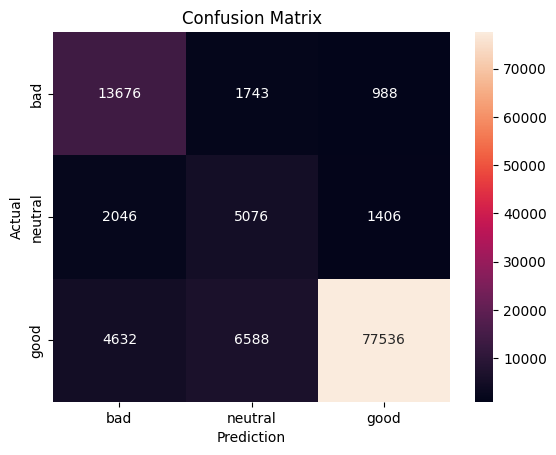

In [25]:
cm = confusion_matrix(y_true, y_pred)
class_names = ["bad", "neutral", "good"]
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

sns.heatmap(cm_df, annot=True, fmt="d")
plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.title('Confusion Matrix')
plt.show()

## **4. Machine Learning techniques implementation**

Tanner's Work so far


In [ ]:
def classify_sentiment(score):
    if score >= 4:
        return 'good'
    if score == 3:
        return 'neutral'
    if score <= 2:
        return 'bad'

df['Sentiment'] = df['Score'].apply(classify_sentiment)

print('Distribution of Sentiment Values:')
print(df['Sentiment'].value_counts())
print()
print('Percentage Distribution of Sentiment Values:')
print(df['Sentiment'].value_counts(normalize=True) * 100)

Distribution of Sentiment Values:
Sentiment
good       443777
bad         82037
neutral     42640
Name: count, dtype: int64

Percentage Distribution of Sentiment Values:
Sentiment
good       78.067355
bad        14.431599
neutral     7.501047
Name: proportion, dtype: float64


In [ ]:
#NOT FINISHED
#need to use stratified sampling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['Text']
y = df['Sentiment']

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
import nltk
#nltk.download('punkt')
sample_df = df.sample(n=5000, random_state=42)
X = sample_df['Text']
y = sample_df['Sentiment']

sample_df
print(sample_df['Sentiment'].value_counts(normalize=True) * 100)



Sentiment
good       78.38
bad        14.06
neutral     7.56
Name: proportion, dtype: float64


In [ ]:
X_tokenized = X.apply(nltk.word_tokenize)

X_tokenized

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


In [ ]:
#nltk.download('averaged_perceptron_tagger')
X_tagged = X_tokenized.apply(nltk.pos_tag)

X_tagged

In [ ]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
X_entities = X_tagged.apply(nltk.chunk.ne_chunk)

X_entities

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

In [ ]:
# Apply VADER sentiment analysis on each text review
sia = SentimentIntensityAnalyzer()
sample_df['VADER_Negative'] = X.apply(lambda x: sia.polarity_scores(x)['neg'])
sample_df['VADER_Neutral'] = X.apply(lambda x: sia.polarity_scores(x)['neu'])
sample_df['VADER_Positive'] = X.apply(lambda x: sia.polarity_scores(x)['pos'])
sample_df['VADER_Compound'] = X.apply(lambda x: sia.polarity_scores(x)['compound'])

sample_df.head()

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(X)

In [ ]:
vader_features = sample_df[['VADER_Negative', 'VADER_Neutral', 'VADER_Positive', 'VADER_Compound']].values
X = np.hstack([tfidf_matrix.toarray(), vader_features])

In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse import hstack

vader_features_sparse = csr_matrix(vader_features)  #convert to sparse
X = hstack([tfidf_matrix, vader_features_sparse])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
logreg = LogisticRegression(multi_class='multinomial', max_iter=500, random_state=42)

In [ ]:
y_train_pred = logreg.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

print("\nTrain Classification Report:")
print(classification_report(y_train, y_train_pred))

# Print the confusion matrix for the training set
print("\nTrain Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))


In [ ]:
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
